In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/heart_disease_health_indicators.csv')

data.head()
# Split features (X) and target (y)
X = data.drop(columns=['HeartDiseaseorAttack'])
y = data['HeartDiseaseorAttack']


In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [25]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Build MLP model with Batch Normalization, L1 & L2 regularization
model = Sequential()

# Input layer and first hidden layer with L1 and L2 regularization
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu',
                kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))  # Optional: Dropout to reduce overfitting

# Second hidden layer with L1 and L2 regularization
model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(BatchNormalization())  # Adding batch normalization
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Compile the model
optimizer = Adam(learning_rate=0.001)  # Initial learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model with early stopping and adaptive learning rate
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/10
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8602 - loss: 0.8714 - val_accuracy: 0.9063 - val_loss: 0.2742 - learning_rate: 0.0010
Epoch 2/10
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9067 - loss: 0.2750 - val_accuracy: 0.9070 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 3/10
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9052 - loss: 0.2735 - val_accuracy: 0.9069 - val_loss: 0.2644 - learning_rate: 0.0010
Epoch 4/10
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9061 - loss: 0.2680 - val_accuracy: 0.9066 - val_loss: 0.2589 - learning_rate: 0.0010
Epoch 5/10
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9044 - loss: 0.2695 - val_accuracy: 0.9059 - val_loss: 0.2585 - learning_rate: 0.0010
Epoch 6/10
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9053 - loss: 0.2685 - val_accuracy: 0.9060 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 7/10
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9

In [28]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9078 - loss: 0.2544
Test Accuracy: 0.9085407853126526


In [29]:
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
print(cm)

1586/1586 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
[[45994    46]
 [ 4594    99]]


In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      1.00      0.95     46040
           1       0.68      0.02      0.04      4693

    accuracy                           0.91     50733
   macro avg       0.80      0.51      0.50     50733
weighted avg       0.89      0.91      0.87     50733



1586/1586 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


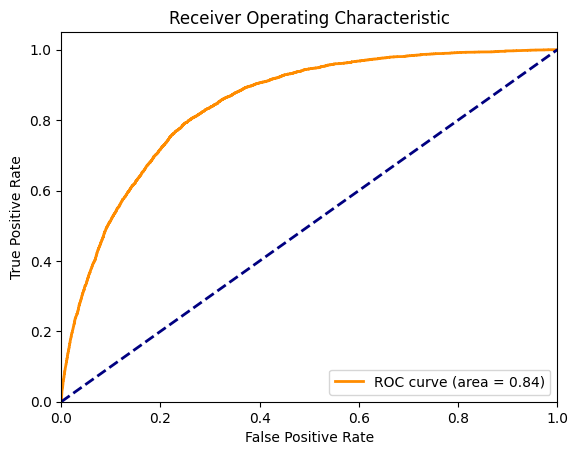

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

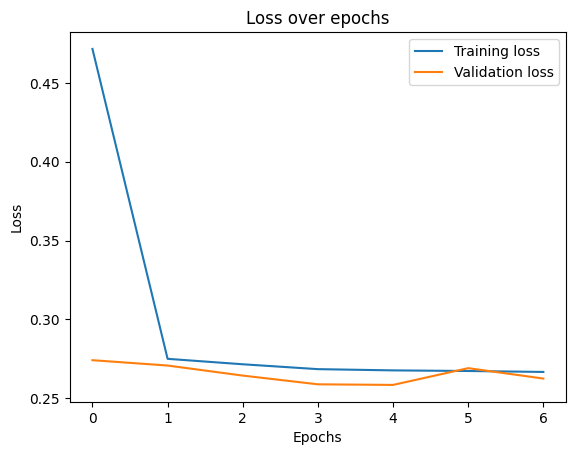

In [32]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [15]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(buildr_model, objective='val_accuracy', max_trials=5)
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

Trial 5 Complete [00h 02m 01s]
val_accuracy: 0.9080224633216858

Best val_accuracy So Far: 0.9081949591636658
Total elapsed time: 00h 12m 28s


In [16]:
best_model = tuner.get_best_models()[0]

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
